In [1]:
import numpy as np
import pandas as pd
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as ss
from sklearn.preprocessing import StandardScaler
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from lightgbm import LGBMRegressor, plot_importance
#from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import RobustScaler, QuantileTransformer, MinMaxScaler, PowerTransformer
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
#from mlxtend.regressor import StackingCVRegressor
from datetime import datetime

In [2]:
os.chdir('D:\\NIA\\선택과제\\2021년_미래기술_챌린지_211002\\1. 이커머스 FC주문 데이터')

df = pd.read_csv('df출고.csv')

C:\Users\tjddl\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df출고 = df[['창고코드','고객사코드','품목코드','품목수량','권역구분','weekdays','holidays','date','month','day_of_month']]
df출고

,창고코드,고객사코드,품목코드,품목수량,권역구분,weekdays,holidays,date,month,day_of_month
0,KX007,90001443,5161917826,4,8,0,1,2021-03-01 00:00:00,3,1
1,KX007,90001341,598604962-4,1,3,0,1,2021-03-01 00:00:00,3,1
2,KX007,90001541,4861386623_4,1,41,0,1,2021-03-01 00:00:00,3,1
3,KX007,90001542,4884978039_1,1,21,0,1,2021-03-01 00:00:00,3,1
4,KX007,90001542,4977419343_1,1,3,0,1,2021-03-01 00:00:00,3,1
...,...,...,...,...,...,...,...,...,...,...
1496515,KX007,90001302,5526911305_28,1,21,2,0,2021-06-30 00:00:00,6,30
1496516,KX007,90001682,5048285001,1,21,2,0,2021-06-30 00:00:00,6,30
1496517,KX007,90001682,5417720634,1,21,2,0,2021-06-30 00:00:00,6,30
1496518,KX007,90001302,575871584,1,7,2,0,2021-06-30 00:00:00,6,30


##  3,4,5월의 품목수량의 TO,평균 및 표준편차 도출
*고객사코드, 품목코드, 권역별로 도출

*같은 품목이나 다른 고객사에서 판매했던 이력 존재

*권역별 주문량이 차이가 있기에 더 세부적으로 주문된 품목수량을 도출

In [4]:
df_345 = df출고[df출고.month != 6]
df_1 = df_345.groupby(['고객사코드','품목코드','권역구분'])['품목수량'].agg([('품목수량_mean','mean'),
                                                      ('품목수량_std','std'), ('TO','sum')]).reset_index()
df_1

,고객사코드,품목코드,권역구분,품목수량_mean,품목수량_std,TO
0,90001302,1001067355,16,1.0,NaN,1
1,90001302,1001085318,62,1.0,NaN,1
2,90001302,1001240388,1,1.0,NaN,1
3,90001302,1001240388,8,1.0,NaN,1
4,90001302,1001240388,11,2.0,1.414214,4
...,...,...,...,...,...,...
195670,90001683,726388162_3,38,1.0,NaN,1
195671,90001683,726388162_3,39,1.0,NaN,1
195672,90001683,726388162_3,44,1.0,NaN,1
195673,90001683,726388162_3,47,1.0,NaN,1


In [5]:
df_1.품목수량_std.value_counts()

0.000000    65533
0.707107     5125
0.577350     2720
0.500000     2023
1.414214     1389
            ...  
1.104943        1
0.878310        1
1.840726        1
0.221572        1
1.800218        1
Name: 품목수량_std, Length: 6987, dtype: int64

## 일별 판매량 피벗테이블 생성 

In [6]:
df_2 = pd.pivot_table(df_345,
                      index=['고객사코드','품목코드','권역구분'],
                      columns = 'date',
                      values = '품목수량',
                     aggfunc = 'sum').reset_index()
df_2

date,고객사코드,품목코드,권역구분,2021-03-01 00:00:00,2021-03-02 00:00:00,2021-03-03 00:00:00,2021-03-04 00:00:00,2021-03-05 00:00:00,2021-03-06 00:00:00,2021-03-07 00:00:00,...,2021-05-22 00:00:00,2021-05-23 00:00:00,2021-05-24 00:00:00,2021-05-25 00:00:00,2021-05-26 00:00:00,2021-05-27 00:00:00,2021-05-28 00:00:00,2021-05-29 00:00:00,2021-05-30 00:00:00,2021-05-31 00:00:00
0,90001302,1001067355,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,90001302,1001085318,62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,90001302,1001240388,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,90001302,1001240388,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,90001302,1001240388,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195670,90001683,726388162_3,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
195671,90001683,726388162_3,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
195672,90001683,726388162_3,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
195673,90001683,726388162_3,47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


## **앞서 평균, 표준편차를 구한 DF와 일별 판매량이 기록된 DF 병합**

In [7]:
df_abc = pd.merge(df_1, df_2, on=['고객사코드','품목코드','권역구분'],  how='inner') 
df_abc.fillna(0, inplace = True)
df_abc

,고객사코드,품목코드,권역구분,품목수량_mean,품목수량_std,TO,2021-03-01 00:00:00,2021-03-02 00:00:00,2021-03-03 00:00:00,2021-03-04 00:00:00,...,2021-05-22 00:00:00,2021-05-23 00:00:00,2021-05-24 00:00:00,2021-05-25 00:00:00,2021-05-26 00:00:00,2021-05-27 00:00:00,2021-05-28 00:00:00,2021-05-29 00:00:00,2021-05-30 00:00:00,2021-05-31 00:00:00
0,90001302,1001067355,16,1.0,0.000000,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,90001302,1001085318,62,1.0,0.000000,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,90001302,1001240388,1,1.0,0.000000,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,90001302,1001240388,8,1.0,0.000000,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,90001302,1001240388,11,2.0,1.414214,4,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195670,90001683,726388162_3,38,1.0,0.000000,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
195671,90001683,726388162_3,39,1.0,0.000000,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
195672,90001683,726388162_3,44,1.0,0.000000,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
195673,90001683,726388162_3,47,1.0,0.000000,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## **주문량(TO) 을 기준으로  내림차순 정렬**

In [8]:
df_abc = df_abc.sort_values(by='TO', ascending=False).reset_index(drop=True)
df_abc

,고객사코드,품목코드,권역구분,품목수량_mean,품목수량_std,TO,2021-03-01 00:00:00,2021-03-02 00:00:00,2021-03-03 00:00:00,2021-03-04 00:00:00,...,2021-05-22 00:00:00,2021-05-23 00:00:00,2021-05-24 00:00:00,2021-05-25 00:00:00,2021-05-26 00:00:00,2021-05-27 00:00:00,2021-05-28 00:00:00,2021-05-29 00:00:00,2021-05-30 00:00:00,2021-05-31 00:00:00
0,90001441,4609081354_1,16,94.285714,332.731915,1320,0.0,0.0,0.0,0.0,...,11.0,0.0,42.0,1251.0,5.0,0.0,0.0,1.0,0.0,0.0
1,90001542,4658408144_1,16,1.102510,0.396257,1054,25.0,18.0,17.0,7.0,...,7.0,21.0,8.0,4.0,6.0,14.0,31.0,14.0,26.0,23.0
2,90001542,4658408144_1,14,1.107588,0.407942,978,22.0,15.0,10.0,10.0,...,16.0,14.0,3.0,9.0,5.0,15.0,38.0,11.0,23.0,26.0
3,90001542,4658408144_1,10,1.089286,0.376483,976,9.0,16.0,11.0,8.0,...,10.0,19.0,5.0,9.0,4.0,21.0,31.0,8.0,27.0,25.0
4,90001441,4609081354_1,56,910.000000,0.000000,910,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,910.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195670,90001441,4890289302_2,4,1.000000,0.000000,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
195671,90001441,4890289302_1,61,1.000000,0.000000,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
195672,90001441,4890289302_1,58,1.000000,0.000000,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
195673,90001441,4890289302_1,55,1.000000,0.000000,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **주문율(TO%) 도출** 

* 고객사, 품목코드 일별 판매수량 총합의 비율(Turn Over Rate)을 구해 TO% 변수 생성
* TO% 변수의 정확성을 검증하기 위해 누적 TO% 컬럼 생성

In [9]:
df_abc['TO%'] = (100*df_abc['TO']/df_abc['TO'].sum())
#sort 
df_abc.sort_values(['TO%'],ascending=False, inplace=True, ignore_index=True)
df_abc['TO%_CS'] = df_abc['TO%'].cumsum()

## **SKU 비율에 따른 ABC 클래스를 지정**
* 상기데이터에선 품목코드를 SKU로 지정
* A클래스의 SKU는 5% 이내, B클래스는 50% 이내, 나머지는 C클래스로 지정
* ABC는 파레토의 법칙을 기반으로하여 고객사 수요가 전체 수요 비율의 얼마를 차지하는지를 구하여 회전율(TO)이 높고 변동성이 낮은 순으로 A,B,C클래스를 지정

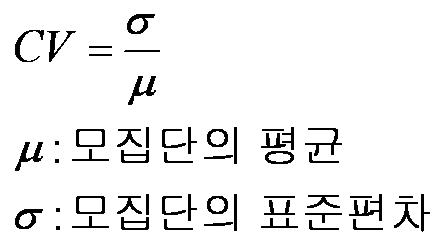

## [SKU_ID] : 각 품목코드에 SKU 인덱스를 부여
## [SKU_%] : 각 품목코드가 전체 품목코드의  차지하는 비율


*  n_a는 전체 SKU 비율의 5%, n_b는 50%로 지정 
*  n_a, n_b 갯수의 -1 만큼 A B 클래스를 지정하고 n_a, n_b에 속해지지 않는 고객사코드는 C 클래스로 지정 
*  to_a, to_b는 n_a, n_b 중 주문율**[TO%]**이 가장 큰 값으로 지정 



  

In [107]:
# A, B, C on SKU Number
n_sku = len(df_2)
n_a, n_b = int(0.2*n_sku), int(0.5*n_sku)
df_abc['SKU_ID'] = pd.Series(range(1, len(df_abc) + 1)).astype(int)
df_abc['SKU_%'] = (100 * pd.Series(range(1, len(df_abc) + 1)) / len(df_abc))

df_abc['ABC'] = pd.Series(range(len(df_abc))).apply(lambda t: 'A' if t <=n_a-1  else 'B' if t <= n_b-1 else 'C')
##이미 수요율을 내림차순으로 데이터 정렬했으니 다음과 같은 방법으로 구분 가능

# A, B, C on turnover
##A,B,C 경계를 만들어줌.
to_a, to_b = df_abc[df_abc['SKU_ID']==n_a]['TO%'].max(), df_abc[df_abc['SKU_ID']==n_b]['TO%'].max()
## 순수 TO%값만 도출하기 위해 max()
##이미 수요율을 내림차순으로 데이터 정렬했으니 다음과 같은 방법으로 구분 가능

In [108]:
n_b

97837

In [109]:
df_abc[df_abc['SKU_ID']==n_a]['TO%']

39134    0.000531
Name: TO%, dtype: float64

In [110]:
df_abc

,고객사코드,품목코드,권역구분,품목수량_mean,품목수량_std,TO,2021-03-01 00:00:00,2021-03-02 00:00:00,2021-03-03 00:00:00,2021-03-04 00:00:00,...,2021-05-28 00:00:00,2021-05-29 00:00:00,2021-05-30 00:00:00,2021-05-31 00:00:00,TO%,TO%_CS,SKU_ID,SKU_%,ABC,CV
0,90001441,4609081354_1,16,94.285714,332.731915,1320,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.100143,0.100143,1,0.000511,A,3.528975
1,90001542,4658408144_1,16,1.102510,0.396257,1054,25.0,18.0,17.0,7.0,...,31.0,14.0,26.0,23.0,0.079963,0.180107,2,0.001022,A,0.359414
2,90001542,4658408144_1,14,1.107588,0.407942,978,22.0,15.0,10.0,10.0,...,38.0,11.0,23.0,26.0,0.074197,0.254304,3,0.001533,A,0.368315
3,90001542,4658408144_1,10,1.089286,0.376483,976,9.0,16.0,11.0,8.0,...,31.0,8.0,27.0,25.0,0.074045,0.328349,4,0.002044,A,0.345624
4,90001441,4609081354_1,56,910.000000,0.000000,910,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.069038,0.397387,5,0.002555,A,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195670,90001302,4844159329,10,1.000000,0.000000,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000076,99.999697,195671,99.997956,C,0.000000
195671,90001302,4844159329,12,1.000000,0.000000,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000076,99.999772,195672,99.998467,C,0.000000
195672,90001302,4844159329,16,1.000000,0.000000,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.000076,99.999848,195673,99.998978,C,0.000000
195673,90001302,4844158392,54,1.000000,0.000000,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000076,99.999924,195674,99.999489,C,0.000000


### 각 품목의 변동계수 추출

In [111]:
df_abc['CV'] = df_abc['품목수량_std']/df_abc['품목수량_mean'] 

<AxesSubplot:>

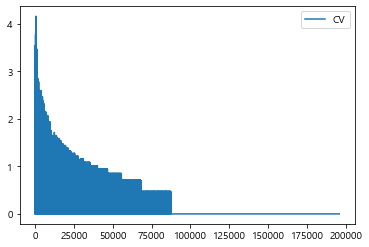

In [126]:
plt.rcParams['font.family'] = 'Malgun Gothic'

(df_abc[['CV']]).plot()

In [127]:
df_abc.value_counts('ABC')

ABC
C    97838
B    58702
A    39135
dtype: int64

In [128]:
df_abc

,index,고객사코드,품목코드,권역구분,품목수량_mean,품목수량_std,TO,2021-03-01 00:00:00,2021-03-02 00:00:00,2021-03-03 00:00:00,...,2021-05-30 00:00:00,2021-05-31 00:00:00,TO%,TO%_CS,SKU_ID,SKU_%,ABC,CV,Normality_p,Not_Normal
0,0,90001441,4609081354_1,16,94.285714,332.731915,1320,0.0,0.0,0.0,...,0.0,0.0,0.100143,0.100143,1,0.000511,A,3.528975,0.002904,False
1,1,90001542,4658408144_1,16,1.102510,0.396257,1054,25.0,18.0,17.0,...,26.0,23.0,0.079963,0.180107,2,0.001022,A,0.359414,0.802299,False
2,2,90001542,4658408144_1,14,1.107588,0.407942,978,22.0,15.0,10.0,...,23.0,26.0,0.074197,0.254304,3,0.001533,A,0.368315,0.703328,False
3,3,90001542,4658408144_1,10,1.089286,0.376483,976,9.0,16.0,11.0,...,27.0,25.0,0.074045,0.328349,4,0.002044,A,0.345624,0.200291,False
4,4,90001441,4609081354_1,56,910.000000,0.000000,910,0.0,0.0,0.0,...,0.0,0.0,0.069038,0.397387,5,0.002555,A,0.000000,0.038426,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195670,195670,90001302,4844159329,10,1.000000,0.000000,1,0.0,0.0,0.0,...,0.0,0.0,0.000076,99.999697,195671,99.997956,C,0.000000,0.023861,False
195671,195671,90001302,4844159329,12,1.000000,0.000000,1,0.0,0.0,0.0,...,0.0,0.0,0.000076,99.999772,195672,99.998467,C,0.000000,0.023860,False
195672,195672,90001302,4844159329,16,1.000000,0.000000,1,0.0,0.0,0.0,...,0.0,1.0,0.000076,99.999848,195673,99.998978,C,0.000000,0.023859,False
195673,195673,90001302,4844158392,54,1.000000,0.000000,1,0.0,0.0,0.0,...,0.0,0.0,0.000076,99.999924,195674,99.999489,C,0.000000,0.023858,False


## ABC분석
* 매출의 대부분을 차지하는 SKU비율 확인

### **총 SKU 비율과 회전율[TO%]의 관계 탐색을 위한 그래프 시각화** 



*  X축을 **[SKU_%]** , Y축을 **[TO%_CS]** 로 지정


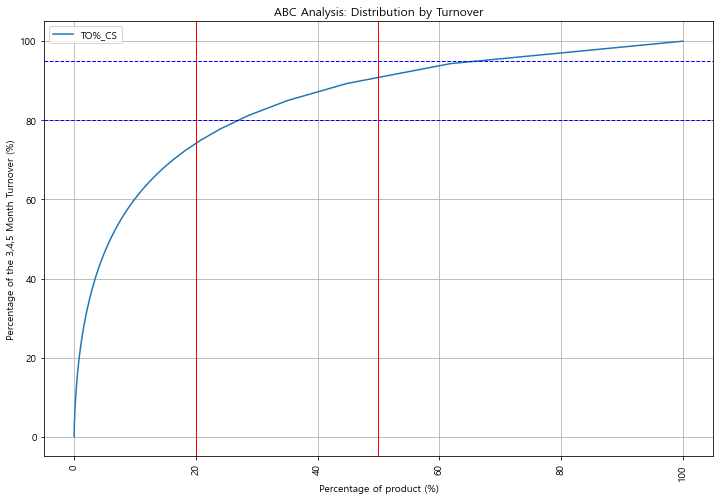

In [129]:
# Distribution by Value
ax = plt.gca()
df_abc.plot(figsize=(12, 8), x='SKU_%', y='TO%_CS', ax =ax, grid = True)
# ABC
# 20%, 50% of SKU Number
ax.axvline(20 , color="red", linestyle="-", linewidth = 1.0)
ax.axvline(50 , color="red", linestyle="-", linewidth = 1.0)
# 20%, 50% of SKU Number
ax.axhline(80 , color="blue", linestyle="--", linewidth = 1.0)
ax.axhline(95 , color="blue", linestyle="--", linewidth = 1.0)
#ax.axhline(95 , color="blue", linestyle="--", linewidth = 1.0)
plt.xlabel('Percentage of product (%)')
plt.xticks(rotation=90)
plt.ylabel('Percentage of the 3,4,5 Month Turnover (%)')
plt.title('ABC Analysis: Distribution by Turnover')
plt.show()

## **고객사, 품목코드별 주문율[TO%]과 수요의 변동성[CV]를 시각화**


*   회전율이 높을 수록 판매가 일정하고 고객사의 수요가 높음을 확인가능 
*   파란색 선 위 아래를 기준으로 고객사가 수요의 변동성의 높낮이를 판단 가능 
*  A 클래스는 붉은색, B 클래스는 초록색, C 클래스는 파란색으로 표시 
*  X축을 **[TO%]**, Y축을 **[CV]** 로 지정


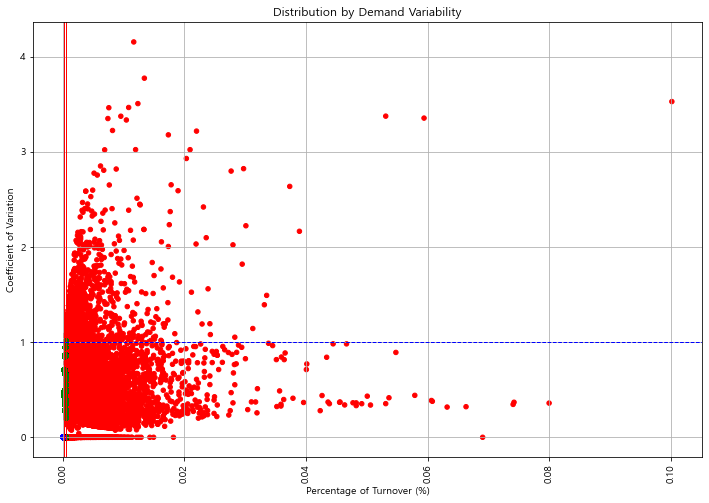

In [125]:
#연간 판매 분포의 변동 계수를 계산
ax = plt.gca()
colors = {'A':'red', 'B':'green', 'C':'blue'}
# Remove Outliers
df_plot = df_abc.copy()
df_plot.plot.scatter(figsize=(12, 8), x='TO%', y='CV', color=df_plot['ABC'].map(colors) ,ax =ax, grid = True)
# ABC
# A, B and C
##to_a, to_b는 tuneover 기준점
ax.axvline(to_a , color="red", linestyle="-", linewidth = 1.0)
ax.axvline(to_b , color="red", linestyle="-", linewidth = 1.0)
# 20%, 50% of SKU Number
ax.axhline(1 , color="blue", linestyle="--", linewidth = 1.0)
plt.xlabel('Percentage of Turnover (%)')
plt.xticks(rotation=90)
#plt.xticks(np.arange(0, 1, 0.001))

plt.ylabel('Coefficient of Variation')
plt.title('Distribution by Demand Variability')
plt.show()

# **ABC 각 클래스의 정규성 검정을 위해 샤피로 윌크 검정실시**



*   상기 결과에서는 대립가설이 기각되고 귀무가설을 채택 
*  귀무 가설을 채택함으로써 정규성이 위배되지 않음



In [118]:
df_abc1 = df_abc[['CV','TO%','TO%_CS','SKU_%']]

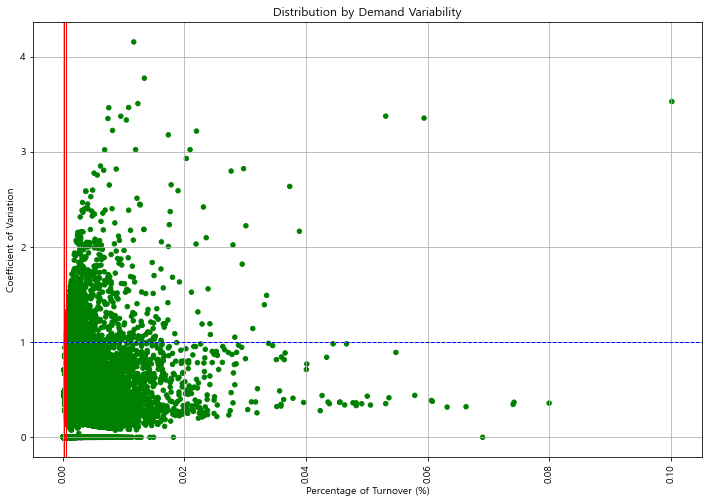

In [119]:
# Normalility Test
df_abc['Normality_p'] = df_abc1.apply(lambda row : ss.shapiro(row)[1], axis = 1)
alpha = 0.001
df_abc['Not_Normal'] = df_abc['Normality_p'] < alpha

# Scatter Plot (ABC, CV)
ax = plt.gca()
## plt.gca() : 현재 Axex객체를 반환
colors = {False:'green', True:'red'}
# Remove Outliers
df_plot = df_abc[df_abc['CV']<8].copy()
df_plot.plot.scatter(figsize=(12, 8), x='TO%', y='CV', color=df_plot['Not_Normal'].map(colors), ax =ax, grid = True)
# ABC
# A, B and C
ax.axvline(to_a , color="red", linestyle="-", linewidth = 1.0)
ax.axvline(to_b , color="red", linestyle="-", linewidth = 1.0)
# 20%, 50% of SKU Number
ax.axhline(1 , color="blue", linestyle="--", linewidth = 1.0)
plt.xlabel('Percentage of Turnover (%)')
plt.xticks(rotation=90)
plt.ylabel('Coefficient of Variation')
plt.title('Distribution by Demand Variability')
plt.show()

* 모두 정규성을 띈다.

### 클래스별 분포 확인

In [130]:
df_abc.reset_index(inplace = True)

In [131]:
df_abc.Not_Normal.value_counts()

False    195675
Name: Not_Normal, dtype: int64

In [132]:
df_abc.ABC.value_counts()

C    97838
B    58702
A    39135
Name: ABC, dtype: int64

### 클래스별 커널밀도분포 확인

C:\Users\tjddl\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\tjddl\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\tjddl\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

<AxesSubplot:ylabel='Density'>

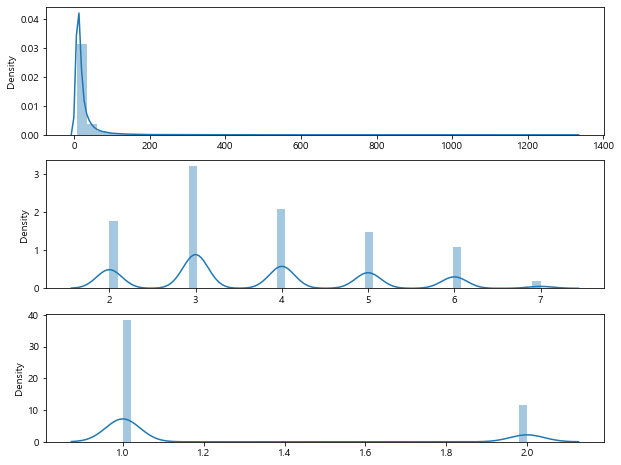

In [133]:
fig = plt.figure(figsize = (10,8))

ax1 = fig.add_subplot(3,1,1)
sns.distplot(df_abc[(df_abc.Not_Normal == False) & (df_abc.ABC == 'A')][['TO']])

ax2 = fig.add_subplot(3,1,2)
sns.distplot(df_abc[(df_abc.Not_Normal == False) & (df_abc.ABC == 'B')][['TO']])

ax3 = fig.add_subplot(3,1,3)
sns.distplot(df_abc[(df_abc.Not_Normal == False) & (df_abc.ABC == 'C')][['TO']])

In [134]:
df_abc.to_csv('D:\\NIA\\선택과제\\2021년_미래기술_챌린지_211002\\1. 이커머스 FC주문 데이터\\df_abc.csv')